## Importing essential libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam


## Loading the data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

## Preproccesing and augmentation

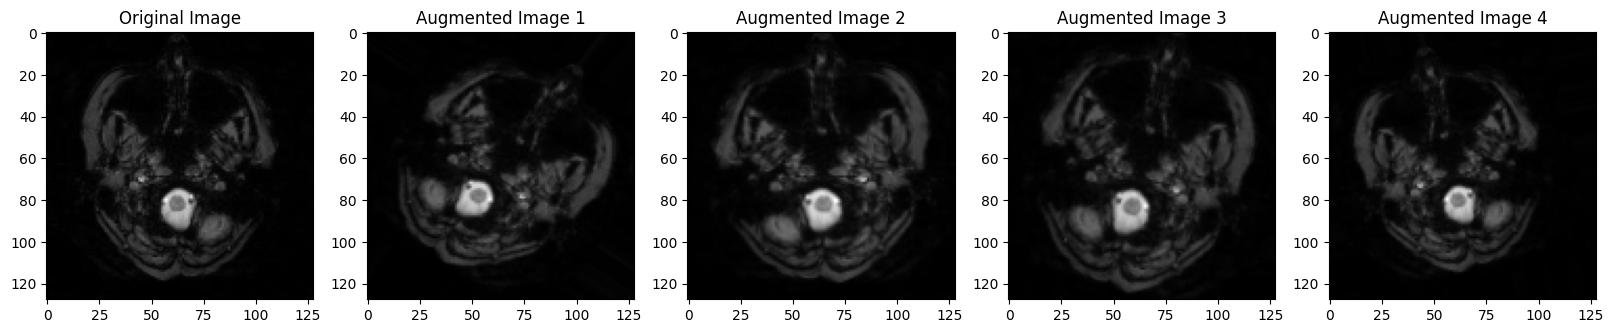

Finished processing images for label 'MCI'.
Number of images for label 'MCI': 3445
Finished processing images for label 'AD'.
Number of images for label 'AD': 4825
There are 8270 images in the 'images' variable.
There are 8270 image labels in the 'image_labels' variable.
There are 2 unique labels in the 'image_labels_encoded' variable.
The unique labels are: [0 1]
The counts of each label are: [4825 3445]


In [ ]:
image_dir = folder_path

labels = ["MCI", "AD"]

image_size = (128, 128)

rescale = 1./255

augmentation_params = dict(horizontal_flip=True, shear_range=0.2, height_shift_range=0.1, rotation_range=45, zoom_range=[0.9, 1.1])

images = []
image_labels = []

datagen = ImageDataGenerator(**augmentation_params)

first_image = True

for label in labels:

    for filename in os.listdir(os.path.join(image_dir, label)):

        img = cv2.imread(os.path.join(image_dir, label, filename), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, image_size)

        img = img * rescale

        img_4d = img.reshape((1,) + img.shape + (1,))

        i = 0
        for batch in datagen.flow(img_4d, batch_size=1):

            images.append(batch[0])
            image_labels.append(label)
            i += 1
            if i >= 5:
                break

        if first_image:
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 5, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            for j in range(4):
                plt.subplot(1, 5, j+2)
                plt.imshow(images[j].reshape(image_size), cmap='gray')
                plt.title(f'Augmented Image {j+1}')
            plt.show()
            first_image = False
    print(f"Finished processing images for label '{label}'.")
    print(f"Number of images for label '{label}': {image_labels.count(label)}")



# Convert the lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

print(f"There are {len(images)} images in the 'images' variable.")

# Convert labels to integers then one-hot encode
encoder = LabelEncoder()
image_labels_encoded = encoder.fit_transform(image_labels)
image_labels_categorical = to_categorical(image_labels_encoded)

print(f"There are {len(image_labels)} image labels in the 'image_labels' variable.")

# Now, print the unique labels and their counts
unique_labels, counts = np.unique(image_labels_encoded, return_counts=True)
print(f"There are {len(unique_labels)} unique labels in the 'image_labels_encoded' variable.")
print("The unique labels are:", unique_labels)
print("The counts of each label are:", counts)

## Showing the statistical distribution of the classes before and after the addition of images

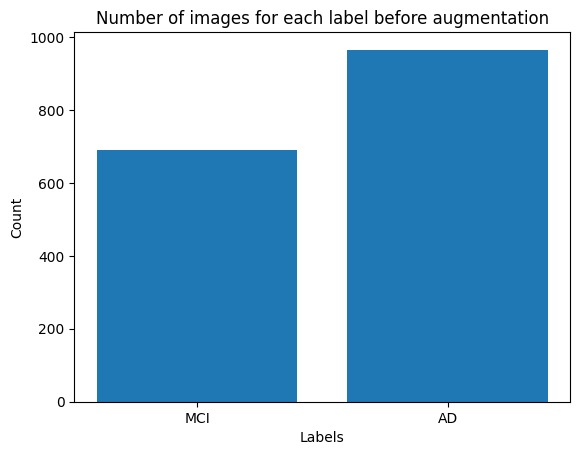

In [ ]:
import matplotlib.pyplot as plt

count_MCI = 0
count_AD = 0

for label in labels:

    for filename in os.listdir(os.path.join(image_dir, label)):

        if label == 'MCI':
            count_MCI += 1
        else:
            count_AD += 1

labels = ['MCI', 'AD']
counts = [count_MCI, count_AD]

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of images for each label before augmentation')
plt.show()


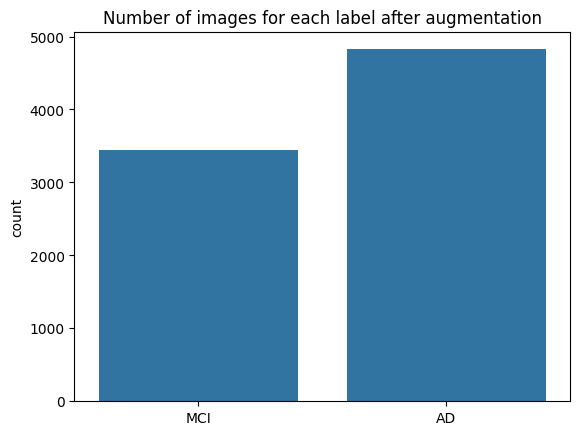

In [ ]:
import random
import seaborn as sns

def display_random_images(images, labels):
    plt.figure(figsize=(20, 10))
    for i in range(5):

        index = random.randint(0, len(images) - 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(images[index].reshape(image_size), cmap='gray')
        plt.title(f'Image {i+1}, Label: {labels[index]}')
    plt.show()

sns.countplot(x=image_labels)
plt.title('Number of images for each label after augmentation')
plt.show()


## Displaying five random images from the new dataset

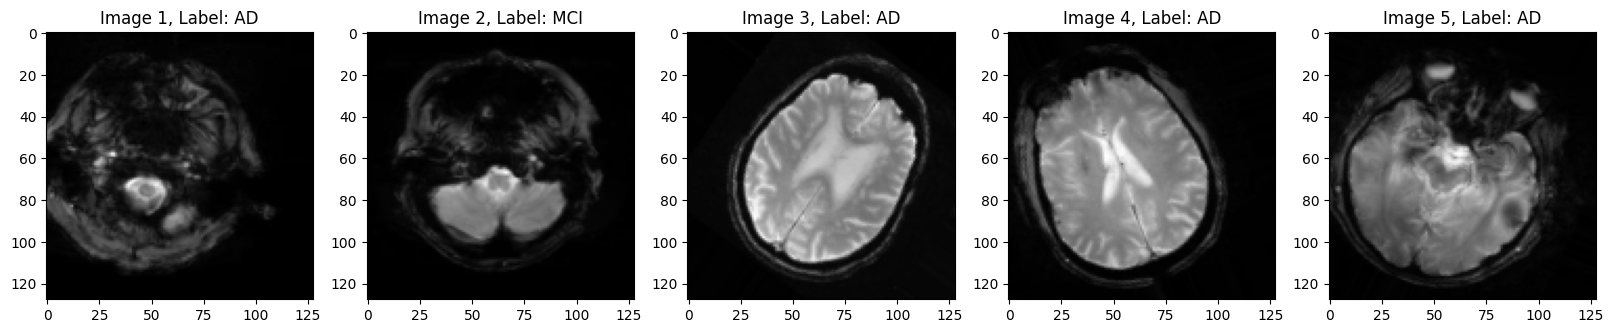

In [ ]:
display_random_images(images, image_labels)

## Splitting the data
**Split the data into training and testing sets (95% training, 5% testing)**

**Further split the training data into training and validation sets (90% training, 10% validation)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, image_labels_categorical, test_size=0.05, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


## Defining and compiling the proposed model, model_test1, model_test2

In [ ]:
from keras.losses import CategoricalCrossentropy

# Define the optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Define the Glorot uniform initializer
initializer = glorot_uniform(seed=42)

# Define the model
model_proposed = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Set number of units to 2 for two classes
])

model_proposed.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
model_proposed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                        

##Fitting and executing the Proposed model ( batch_size = 64 )


In [ ]:
# Fit the Proposed model
history_proposed_64 = model_proposed.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=20)


Epoch 1/20
111/111 [==============================] - 24s 80ms/step - loss: 0.9417 - accuracy: 0.6171 - val_loss: 1.1117 - val_accuracy: 0.4975
Epoch 2/20
111/111 [==============================] - 7s 65ms/step - loss: 0.5835 - accuracy: 0.7025 - val_loss: 1.0105 - val_accuracy: 0.4249
Epoch 3/20
111/111 [==============================] - 7s 64ms/step - loss: 0.5169 - accuracy: 0.7451 - val_loss: 1.1359 - val_accuracy: 0.4682
Epoch 4/20
111/111 [==============================] - 7s 63ms/step - loss: 0.4431 - accuracy: 0.7914 - val_loss: 4.0786 - val_accuracy: 0.5204
Epoch 5/20
111/111 [==============================] - 7s 65ms/step - loss: 0.3750 - accuracy: 0.8297 - val_loss: 2.3040 - val_accuracy: 0.5471
Epoch 6/20
111/111 [==============================] - 7s 65ms/step - loss: 0.2932 - accuracy: 0.8775 - val_loss: 1.6117 - val_accuracy: 0.6145
Epoch 7/20
111/111 [==============================] - 7s 66ms/step - loss: 0.1986 - accuracy: 0.9194 - val_loss: 0.6255 - val_accuracy: 0.749

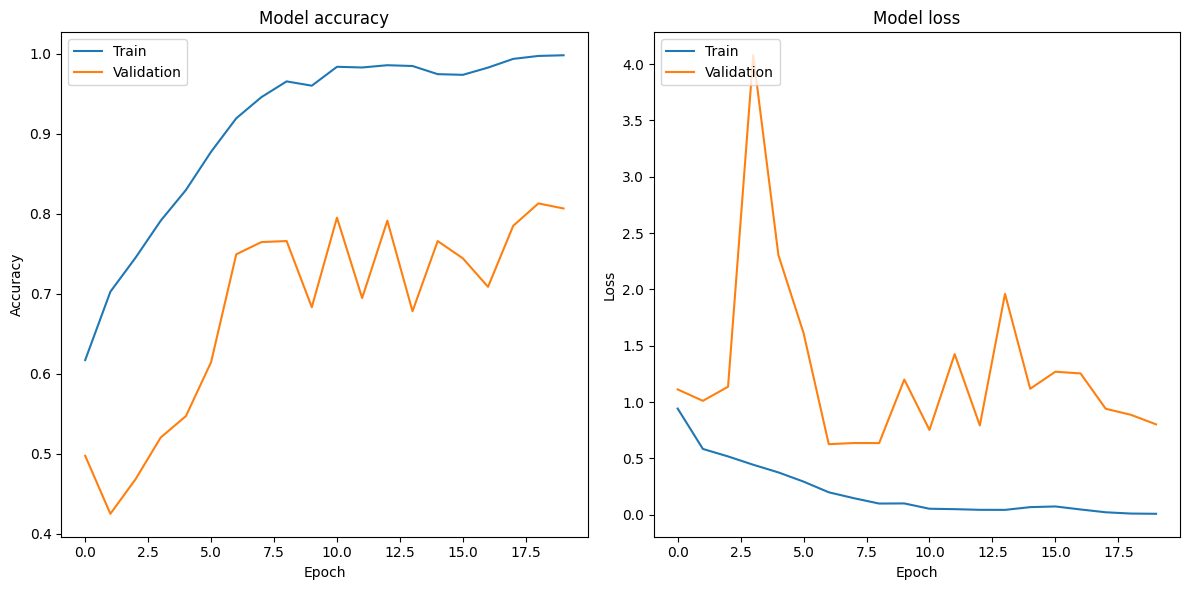

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_proposed_64.history['accuracy'])
plt.plot(history_proposed_64.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_proposed_64.history['loss'])
plt.plot(history_proposed_64.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


##Fitting and executing the Proposed model ( batch_size = 32)

In [ ]:
# Fit the Proposed model
history_proposed_32 = model_proposed.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
221/221 [==============================] - 9s 35ms/step - loss: 0.5077 - accuracy: 0.8277 - val_loss: 0.9375 - val_accuracy: 0.6730
Epoch 2/20
221/221 [==============================] - 8s 35ms/step - loss: 0.3807 - accuracy: 0.8355 - val_loss: 0.7157 - val_accuracy: 0.7214
Epoch 3/20
221/221 [==============================] - 8s 35ms/step - loss: 0.1687 - accuracy: 0.9325 - val_loss: 0.6614 - val_accuracy: 0.7723
Epoch 4/20
221/221 [==============================] - 8s 35ms/step - loss: 0.0599 - accuracy: 0.9782 - val_loss: 0.8868 - val_accuracy: 0.7455
Epoch 5/20
221/221 [==============================] - 8s 35ms/step - loss: 0.0279 - accuracy: 0.9901 - val_loss: 0.8696 - val_accuracy: 0.7786
Epoch 6/20
221/221 [==============================] - 8s 34ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 1.1201 - val_accuracy: 0.7545
Epoch 7/20
221/221 [==============================] - 8s 35ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 1.1419 - val_accuracy: 0.7443

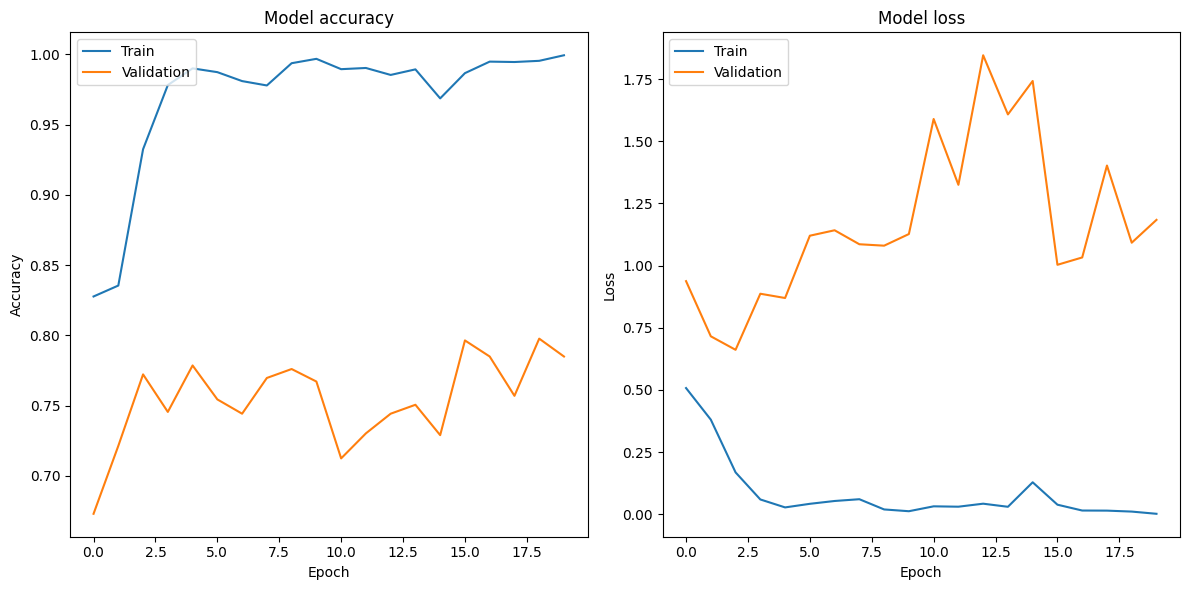

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_proposed_32.history['accuracy'])
plt.plot(history_proposed_32.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_proposed_32.history['loss'])
plt.plot(history_proposed_32.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## ROC curve

13/13 [==============================] - 0s 10ms/step


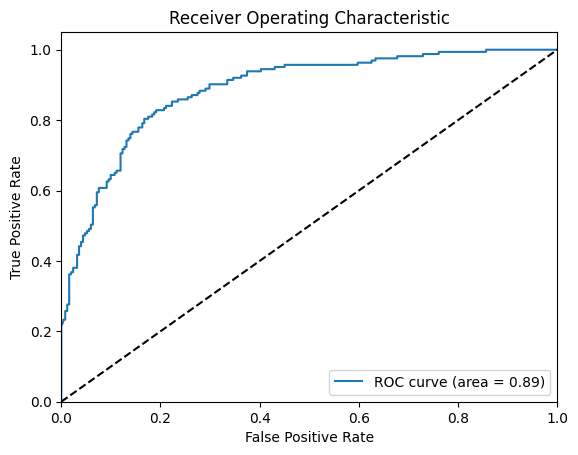

In [ ]:
y_pred_prob = model_proposed.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  # number of classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Analysing the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from keras.metrics import Precision, Recall

y_pred_prob = model_proposed.predict(X_test)

y_pred_class = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test.argmax(axis=1), y_pred_class)

cr = classification_report(y_test.argmax(axis=1), y_pred_class, target_names=['AD', 'MCI'])

auc = roc_auc_score(y_test, model_proposed.predict(X_test))

print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(cr)

print("AUC: ", auc)


13/13 [==============================] - 0s 8ms/step
Confusion Matrix:
[[216  35]
 [ 40 123]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.84      0.86      0.85       251
         MCI       0.78      0.75      0.77       163

    accuracy                           0.82       414
   macro avg       0.81      0.81      0.81       414
weighted avg       0.82      0.82      0.82       414

AUC:  0.8859347884535478


## Adding dropout to the model and analysing it

In [ ]:
from keras.layers import Dropout

# Define the Proposed model with dropout
model_proposed_dropout = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),  # Added dropout
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),  # Added dropout
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Set number of units to 2 for two classes
])

# Use the legacy Adam optimizer
model_proposed_dropout.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Now you can fit the model
history_proposed_dropout = model_proposed_dropout.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=20)


Epoch 1/20
111/111 [==============================] - 15s 106ms/step - loss: 1.2615 - accuracy: 0.5615 - val_loss: 0.7461 - val_accuracy: 0.5649
Epoch 2/20
111/111 [==============================] - 11s 102ms/step - loss: 0.6767 - accuracy: 0.5785 - val_loss: 0.8095 - val_accuracy: 0.5814
Epoch 3/20
111/111 [==============================] - 11s 100ms/step - loss: 0.6767 - accuracy: 0.5816 - val_loss: 1.3658 - val_accuracy: 0.5814
Epoch 4/20
111/111 [==============================] - 11s 102ms/step - loss: 0.6816 - accuracy: 0.5806 - val_loss: 3.2795 - val_accuracy: 0.5814
Epoch 5/20
111/111 [==============================] - 11s 100ms/step - loss: 0.6861 - accuracy: 0.5826 - val_loss: 0.7615 - val_accuracy: 0.5802
Epoch 6/20
111/111 [==============================] - 11s 99ms/step - loss: 0.6704 - accuracy: 0.5809 - val_loss: 0.6616 - val_accuracy: 0.5738
Epoch 7/20
111/111 [==============================] - 11s 100ms/step - loss: 0.6733 - accuracy: 0.5810 - val_loss: 0.7124 - val_acc

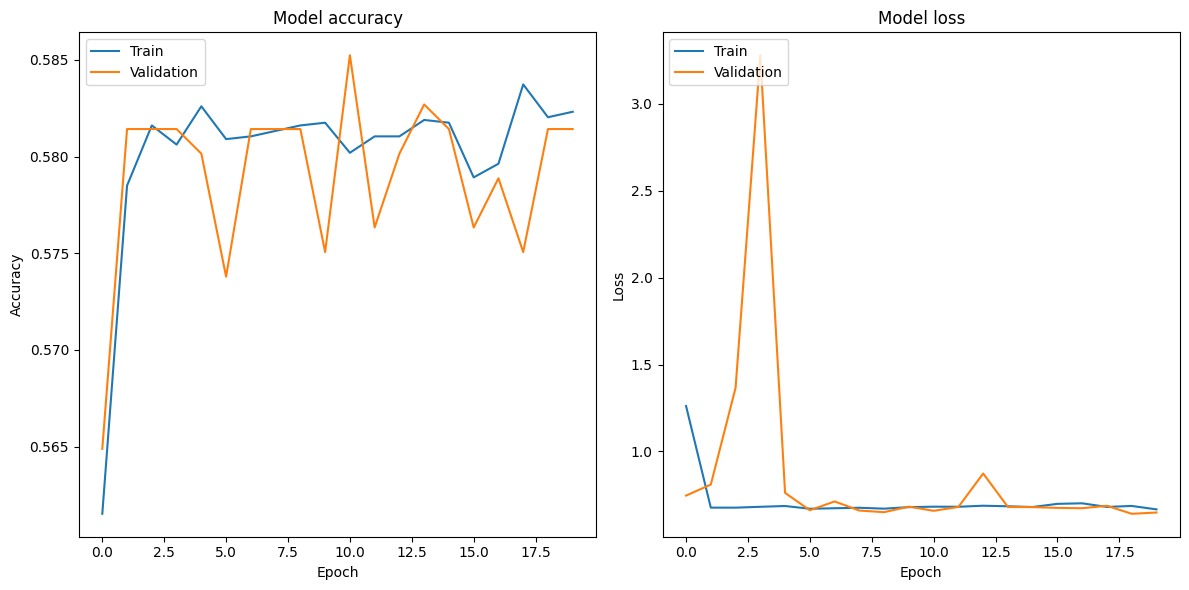

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_proposed_dropout.history['accuracy'])
plt.plot(history_proposed_dropout.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_proposed_dropout.history['loss'])
plt.plot(history_proposed_dropout.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()